In [ ]:
!pip3 install 'git+https://github.com/alexlatchford/pipelines@alexla/AIP-1676#egg=kfp&subdirectory=sdk/python'

In [5]:
# Solved!
import yaml
import kfp
from kfp import compiler, dsl
from kfp.dsl import ContainerOp, python_component, RUN_ID_PLACEHOLDER
from kfp.components import (
    func_to_container_op,
    func_to_component_text,
    load_component_from_text,
)


def pipeline_transformer(op: ContainerOp):
    op.execution_options.caching_strategy.max_cache_staleness = "P0D"
    op.container.set_cpu_request("150m")
    op.container.set_cpu_limit("150m")  # please ensure the limit and requests are equal


def named_op(name: str, func: callable) -> ContainerOp:
    text = yaml.load(func_to_component_text(func), yaml.SafeLoader)
    text["name"] = name
    return load_component_from_text(yaml.dump(text))

In [12]:
def foreach_step(passed_in_split_indexes) -> list:
    print("passed_in_split_indexes", passed_in_split_indexes)
    return [f"{passed_in_split_indexes}_{i}".strip("_") for i in range(1, 3)]


@func_to_container_op
def inner_step(passed_in_split_indexes) -> list:
    print(passed_in_split_indexes)
    return None


def join_results(passed_in_split_indexes="") -> list:
    print("passed_in_split_indexes", passed_in_split_indexes)
    return None

# ParallelFor with join


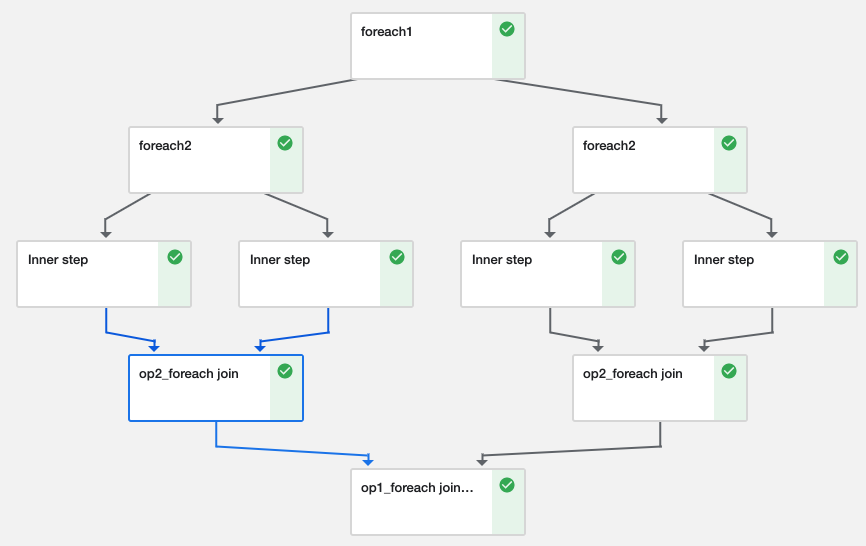


```
Split Outputs for foreach1: [1, 2]

Split Outputs for foreach2: ["1_1",  "1_2"] and ["2_1",  "2_2"]
```

In [13]:
@kfp.dsl.pipeline(name="metaflow_foreach", description="test")
def map_reduce_pipeline():
    op1_foreach = named_op("foreach1", foreach_step)("")
    with kfp.dsl.ParallelFor(op1_foreach.output) as split_1:
        # ** The split_1 becomes inner step Metaflow task_ids

        # foreach
        op2_foreach = named_op("foreach2", foreach_step)(split_1)
        with kfp.dsl.ParallelFor(op2_foreach.output) as split_2:
            op3_inner = inner_step(split_2)
        # ** Join on op2_foreach with split_1
        op_join2 = named_op("op2_foreach join", join_results)(split_1).after(op3_inner)

    # ** Join op1_foreach, but we are not inside a foreach, so no split
    named_op("op1_foreach joinop1_foreach join", join_results)().after(op_join2)

    dsl.get_pipeline_conf().add_op_transformer(pipeline_transformer)


kfp.Client(userid="talebz@zillowgroup.com").create_run_from_pipeline_func(
    map_reduce_pipeline,
    arguments={},
    run_name="nested_join",
    experiment_name="nested_foreaches",
    namespace="aip-example",
)

RunPipelineResult(run_id=1fef8325-84ad-41ea-937f-05d21ac7f6e5)

# Nested ParallelFor with join

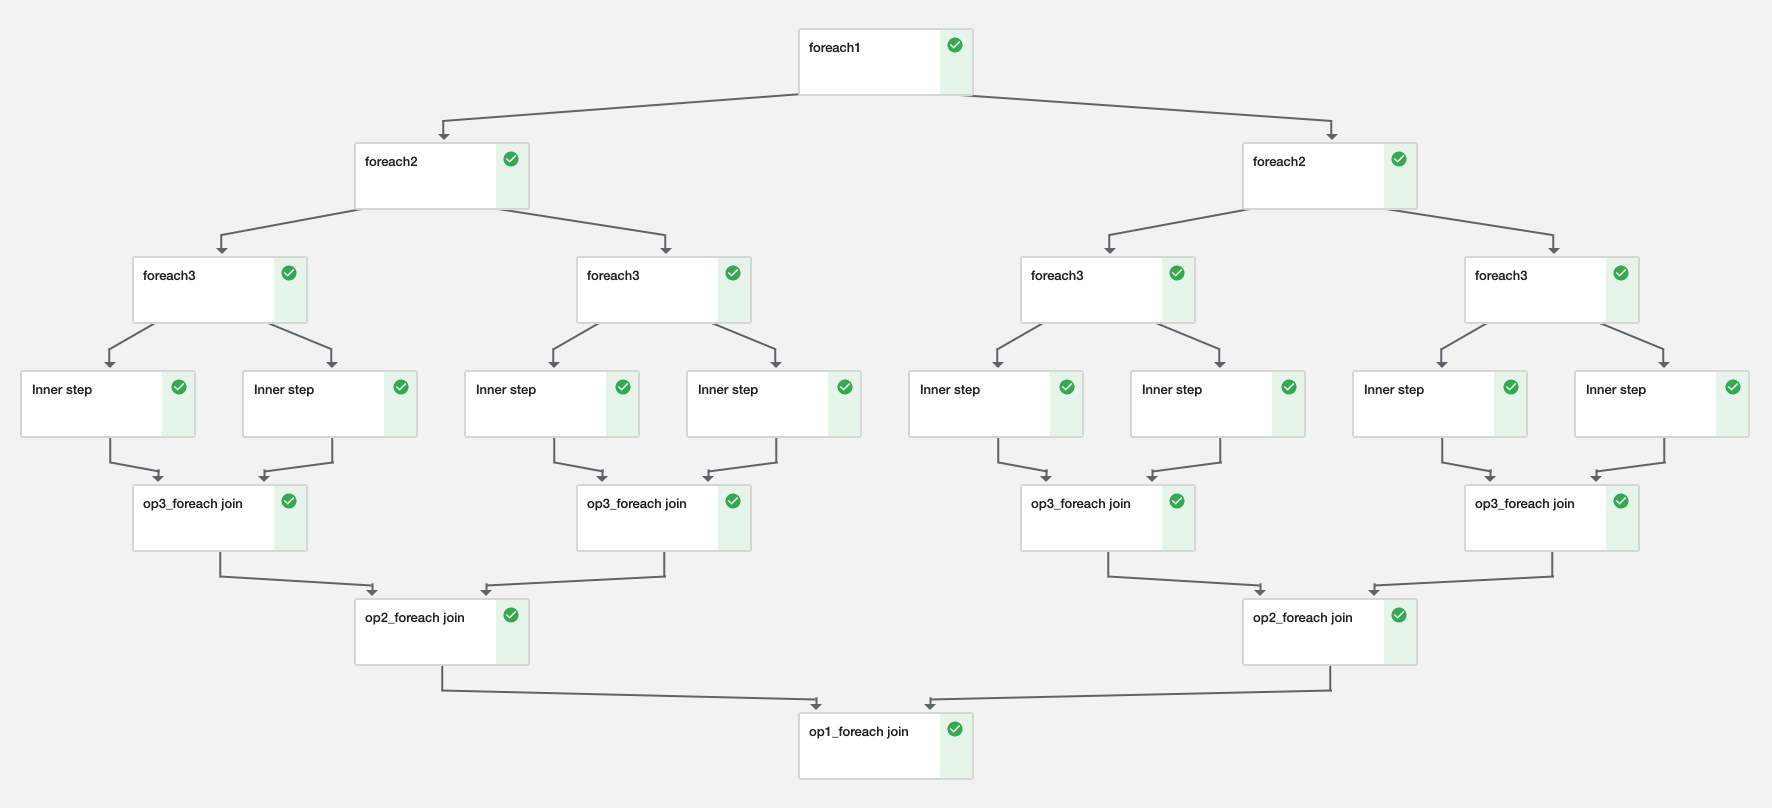


```
Split Outputs for foreach1: [1, 2]

Split Outputs for foreach2: ["1_1",  "1_2"] and ["2_1",  "2_2"]

Split Outputs for foreach3:["2_2_1", "2_2_2"] and ...
```

In [14]:
# nested loops


@kfp.dsl.pipeline(name="test", description="test")
def map_reduce_pipeline():
    op1_foreach = named_op("foreach1", foreach_step)("")
    with kfp.dsl.ParallelFor(op1_foreach.output) as split_1:
        # ** The split_1 becomes inner step Metaflow task_ids

        # foreach
        op2_foreach = named_op("foreach2", foreach_step)(split_1)
        with kfp.dsl.ParallelFor(op2_foreach.output) as split_2:
            # foreach
            op3_foreach = named_op("foreach3", foreach_step)(split_2)
            with kfp.dsl.ParallelFor(op3_foreach.output) as split_3:
                op3_inner = inner_step(split_3)

            # ** Join on op2_foreach with split_1
            op_join3 = named_op("op3_foreach join", join_results)(split_2).after(
                op3_inner
            )

        # ** Join on op2_foreach with split_1
        op_join2 = named_op("op2_foreach join", join_results)(split_1).after(op_join3)

    # ** Join op1_foreach, but we are not inside a foreach, so no split
    named_op("op1_foreach join", join_results)().after(op_join2)

    dsl.get_pipeline_conf().add_op_transformer(pipeline_transformer)


kfp.Client(userid="talebz@zillowgroup.com").create_run_from_pipeline_func(
    map_reduce_pipeline,
    arguments={},
    run_name="map_reduce_pipeline",
    experiment_name="kf-1.0-test-experiment",
    namespace="aip-example",
)

RunPipelineResult(run_id=d5ec63e0-d9de-4172-b52a-9727673376f9)